In [1]:
library(tidyverse)
library(broom)
library(timetk)
library(lubridate)
library(cowplot)
library(prophet)
library(CausalImpact)
library(bsts)
library(forecast)
library(zoo)
library(lmtest)
library(xtable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘cowplot’

The following object is masked from ‘package:lubridate’:

    stamp

Loading required package: Rcpp
Loading required package: rlang

Attaching package: ‘rlang’

The following objects are masked from ‘package:purr

In [2]:
options(mc.cores = parallel::detectCores())

In [3]:
basedir <- "../data/"

In [4]:
.start <- as_date("2003-01-01")

# Load data

In [5]:
usa_infile <- str_c(basedir, "MSDX_day_20180922_newborn_geo_sex_mother.txt")

In [6]:
dat <- 
    readr::read_delim(
        file = usa_infile,
        delim = "\t",
        col_names = c(
            "Newborn", 
            "Birthday",
            "FIPS", 
            "MSA", 
            "Sex",
            "Mother"
        ),
        col_types = "cicccc"
    ) %>%
    dplyr::filter(FIPS != "00000") %>%
    dplyr::mutate(
        Birthdate = .start + Birthday - 1
    ) %>%
    dplyr::select(
        Newborn, Mother, Sex, Birthdate, Birthday, FIPS
    ) 

In [7]:
dat

Newborn,Mother,Sex,Birthdate,Birthday,FIPS
<chr>,<chr>,<chr>,<date>,<int>,<chr>
000003790,000003789,M,2006-02-24,1151,26087
000010647,000010644,M,2007-09-17,1721,17089
000010870,000010865,F,2005-09-28,1002,39023
000010918,000010916,F,2004-05-05,491,34007
000011972,000011971,M,2005-06-11,893,17197
000012016,000012015,F,2004-04-28,484,39023
000012337,000012336,M,2007-03-28,1548,39113
000012605,000012603,F,2006-09-28,1367,18003
000013055,000013053,M,2003-10-04,277,18097


# Analyse data

### Utils

In [8]:
plot_pred <- function(pred, .period, .title, ...) { 
    pred %>%
        ggplot(
            mapping = aes(x = period, y = y)
        ) +
        # All points
        geom_point(size = 1, alpha = 0.8) +
        # Fetal death
        geom_point(
            data = dplyr::filter(
                pred,
                period >= .period & period <= .period + 4
            ),
            size = 2,
            colour = "red",
            alpha = 0.75
        ) +
        # Reduced conceptions
        geom_point(
            data = dplyr::filter(
                pred,
                period >= .period + 7 & period <= .period + 9
            ),
            size = 2,
            colour = "purple",
            alpha = 0.75
        ) +
        # Line plot
        geom_line(alpha = 0.8) +
        # Vertical line at intervention
        geom_vline(
            xintercept = .period,
            linetype = "dashed",
            size = 0.5
        ) +
        # Forecast
        geom_line(
            data = dplyr::filter(
                pred,
                period >= .period
            ),
            mapping = aes(y = yhat),
            colour = "#0072B2",
            na.rm = TRUE,
        ) +
        # Confidence intervals
        geom_ribbon(
            data = dplyr::filter(
                pred,
                period >= .period
            ),
            mapping = aes(ymin = yhat_lower, ymax = yhat_upper),
            fill = "#0072B2",
            na.rm = TRUE,
            alpha = 0.2
        ) +
        # Axes
        scale_x_continuous(
            breaks = seq(from = 1, to = .period + 9, by = 4),
        ) +
        # Title and labels
        labs(x = "Period", y = "SRB", title = .title) +
        # Themes
        theme_cowplot(font_size = 12, font_family = "serif") +
        background_grid(minor = "xy") +
        theme(
            aspect.ratio = 0.4,
            ...
        )
}

In [9]:
add_periods <- function(df, start, intv, len, filter, ...){
    # Remove irrelevant births 
    if(filter){
        df_out <- 
            df %>%
            filter(
                Birthdate <= intv + len * filter - 1
            )
    } else {
        df_out <- df
    }
    
    # Get periods
    intv_day <- as.integer(intv - start + 1)
    residual <- intv_day %% len
    cat(sprintf("Intervention on day %d.\n", intv_day))
    
    df_out <-
        df_out %>%
        mutate(
            day_in_period = (Birthday - residual) %% len + 1,
            period = (Birthday - residual) %/% len + ifelse(residual <= 1, 0, 1) + 1,
            period_start = Birthdate - day_in_period + 1,
            period_end = period_start + len - 1,
        )    
    
    intv_period <-
        df_out %>%
        dplyr::distinct(period_start, period) %>%
        dplyr::filter(
            period_start == intv
        ) %>%
        pull(period)
        
    invisible(list(df = df_out, intv_period = intv_period))
}

In [10]:
get_summarised_data <- function(df) {
    df_out <-
        df %>%
        # Group by period and sum, and then get count
        dplyr::group_by(period, period_start, period_end, Sex) %>%
        dplyr::summarize(Count = n()) %>%
        dplyr::ungroup() %>%
        # Group by period, and then sum (by sex)
        dplyr::group_by(period, period_start, period_end) %>% 
        dplyr::mutate(Sum = sum(Count)) %>% 
        # SRB = M / (M + F)
        dplyr::filter(Sex == "M") %>% 
        dplyr::mutate(y = Count / Sum) %>%
        dplyr::ungroup() %>%
        dplyr::select(-Sex)
}

In [11]:
fit_arima <- function(df, .period = NULL, ...){
    df_train <-
        df %>%
        dplyr::filter(period < .period) %>%
        dplyr::select(y)
    
    fit <- 
        df_train %>%
        auto.arima(...)
}

In [12]:
get_arima_forecasts <- function(fit, df, ...){
    pred <-
        fit %>%
        forecast(
            ...,
        ) %>%
        timetk::tk_tbl() %>%
        dplyr::rename(
            period = index,
            yhat = `Point Forecast`,
            yhat_lower = `Lo 95`,
            yhat_upper = `Hi 95`
        ) %>%
        full_join(x = df, y = .)
}

In [13]:
get_ssm_causal <- function(df, .intv, niter = 2000){
    # Preintervention TS
    y <-
        df %>%
        mutate(
            y = ifelse(period >= .intv, NA, y)
        ) %>%
        pull(y) %>%
        zoo(x = ., order.by = pull(df, period))
    
    # Seasonality and holidays
    ss <- NULL
    ss <- AddLocalLevel(list(), y) # state vectors
    ss <- AddSeasonal(ss, y, nseasons = 4, season.duration = 3)
    
    # Fit model
    .bsts_model <-
        bsts(y, state.specification = ss, niter = niter)
    
    invisible(list(data = y, model = .bsts_model))
}

## Hurricane Katrina (30 August, 2005)

In [14]:
.katrina <- as_date("2005-08-30")

In [15]:
dat_katrina_mo_all <- 
    dat %>%
    add_periods(
        start = .start, intv = `.katrina`, len = 28, filter = 10
    )

Intervention on day 973.


In [16]:
dat_katrina_mo_all$intv_period

[1] 36

In [17]:
df_katrina_mo_all <- 
    dat_katrina_mo_all$df %>%
    get_summarised_data()

In [18]:
df_katrina_mo_all

period,period_start,period_end,Count,Sum,y
<dbl>,<date>,<date>,<int>,<int>,<dbl>
1,2002-12-24,2003-01-20,2632,5088,0.5172956
2,2003-01-21,2003-02-17,3960,7578,0.5225653
3,2003-02-18,2003-03-17,4201,8075,0.5202477
4,2003-03-18,2003-04-14,4216,8054,0.5234666
5,2003-04-15,2003-05-12,4200,8096,0.5187747
6,2003-05-13,2003-06-09,4105,7999,0.5131891
7,2003-06-10,2003-07-07,4105,8043,0.5103817
8,2003-07-08,2003-08-04,4169,8096,0.5149457
9,2003-08-05,2003-09-01,4116,7935,0.5187146


In [19]:
df_katrina_mo_all %>%
    write_delim(
        path = str_c(basedir, "ts_katrina_mo_all.tsv"),
        delim = "\t"
    )

### All states

#### ARIMA

In [19]:
arima_katrina_mo_all <-
    df_katrina_mo_all %>%
    fit_arima(
        .period = dat_katrina_mo_all$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        max.order = 48,
        max.D = 12, 
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [20]:
arima_katrina_mo_all

Series: . 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.5165
s.e.  0.0009

sigma^2 estimated as 2.905e-05:  log likelihood=133.66
AIC=-263.32   AICc=-262.94   BIC=-260.21

In [21]:
resfit_arima_katrina_mo_all <-
    lm(formula = arima_katrina_mo_all$residuals ~ 1)

In [22]:
bg_arima_katrina_mo_all <-
    resfit_arima_katrina_mo_all %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [23]:
print(bg_arima_katrina_mo_all)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 11.548, df = 13, p-value = 0.565



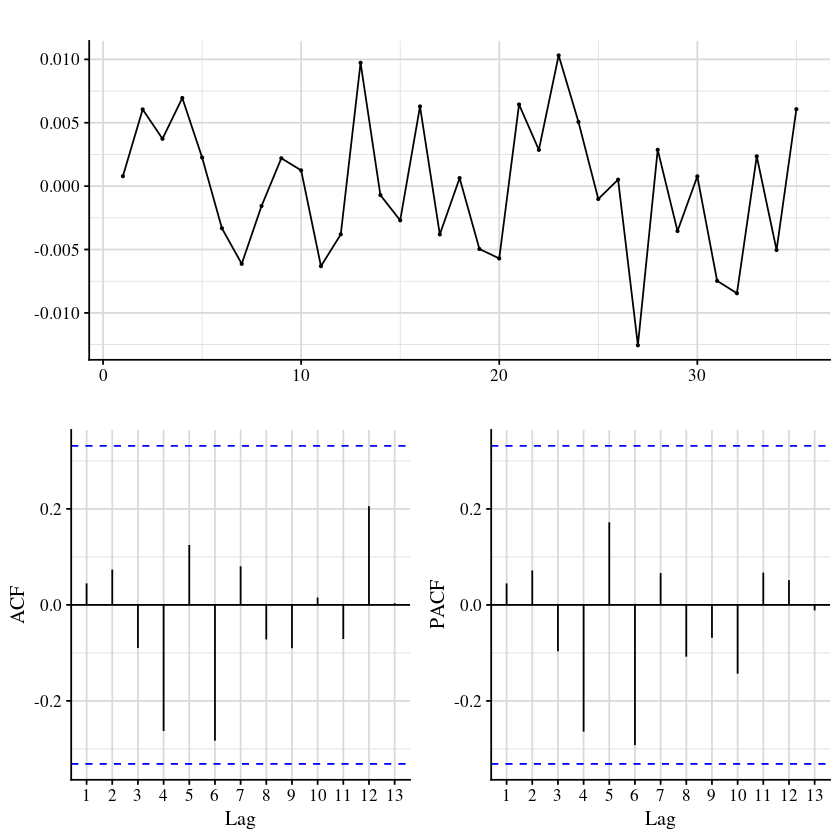

In [24]:
resfit_arima_katrina_mo_all %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [25]:
pred_arima_katrina_mo_all <-
    arima_katrina_mo_all %>%
    get_arima_forecasts(
        df = df_katrina_mo_all,
        h = 10,
        level = 95
    )

Joining, by = "period"

In [26]:
pred_arima_katrina_mo_all

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-24,2003-01-20,2632,5088,0.5172956,NA,NA,NA
2,2003-01-21,2003-02-17,3960,7578,0.5225653,NA,NA,NA
3,2003-02-18,2003-03-17,4201,8075,0.5202477,NA,NA,NA
4,2003-03-18,2003-04-14,4216,8054,0.5234666,NA,NA,NA
5,2003-04-15,2003-05-12,4200,8096,0.5187747,NA,NA,NA
6,2003-05-13,2003-06-09,4105,7999,0.5131891,NA,NA,NA
7,2003-06-10,2003-07-07,4105,8043,0.5103817,NA,NA,NA
8,2003-07-08,2003-08-04,4169,8096,0.5149457,NA,NA,NA
9,2003-08-05,2003-09-01,4116,7935,0.5187146,NA,NA,NA


In [27]:
pred_arima_katrina_mo_all %>%
    dplyr::filter(
        period >= dat_katrina_mo_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:03 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   36 & 0.5193 & 0.5060 & 0.5271 \\ 
     37 & 0.5188 & 0.5060 & 0.5271 \\ 
     38 & 0.5119 & 0.5060 & 0.5271 \\ 
     39 & 0.5148 & 0.5060 & 0.5271 \\ 
     40 & 0.5186 & 0.5060 & 0.5271 \\ 
     41 & 0.5049 & 0.5060 & 0.5271 \\ 
     42 & 0.5161 & 0.5060 & 0.5271 \\ 
     43 & 0.5182 & 0.5060 & 0.5271 \\ 
     44 & 0.5060 & 0.5060 & 0.5271 \\ 
     45 & 0.5100 & 0.5060 & 0.5271 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Hurricane Katrina in all states} 
\end{table}


In [28]:
p_arima_katrina_mo_all <-
    pred_arima_katrina_mo_all %>%
    plot_pred(
        .period = dat_katrina_mo_all$intv_period,
        .title = "Katrina (all states)"
    ) +
    labs(subtitle = "ARIMA")

In [29]:
p_arima_katrina_mo_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_katrina_arima_all_states.pdf")
    )

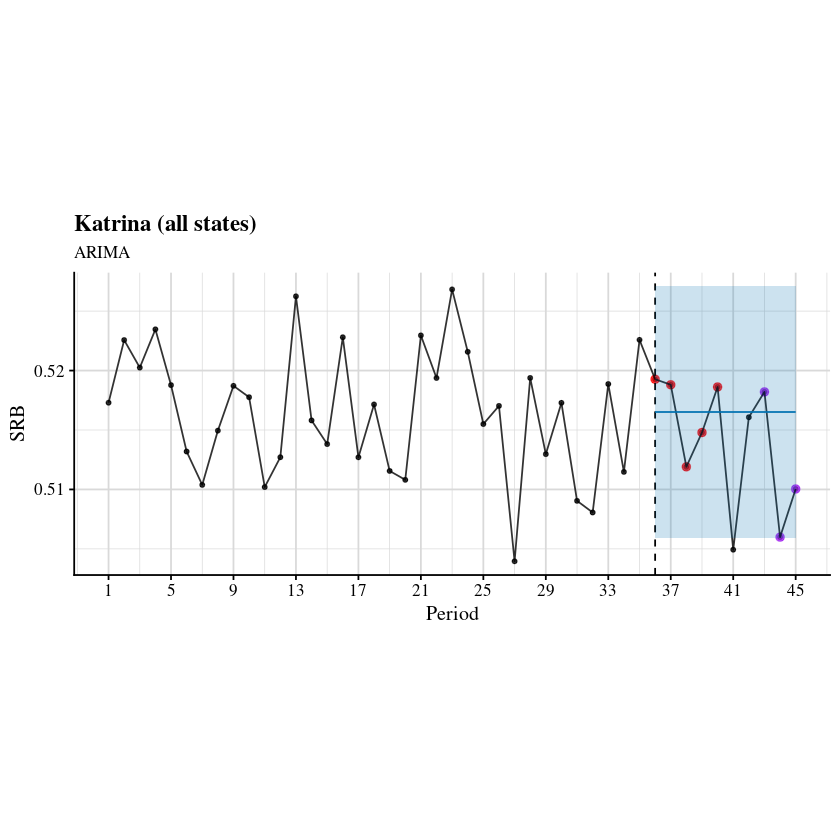

In [30]:
p_arima_katrina_mo_all

#### CausalImpact

In [31]:
bsts_katrina_mo_all <-
    df_katrina_mo_all %>%
    get_ssm_causal(
        .intv = dat_katrina_mo_all$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:05 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:05 2020 =-=-=-=-=


In [32]:
causal_katrina_mo_all <-
    df_katrina_mo_all %>%
    dplyr::filter(
        period >= dat_katrina_mo_all$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_katrina_mo_all$model,
        post.period.response = .
    )

In [33]:
df_causal_katrina_mo_all <-
    causal_katrina_mo_all$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [34]:
pred_causal_katrina_mo_all <-
    df_causal_katrina_mo_all %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [35]:
pred_causal_katrina_mo_all %>%
    dplyr::filter(period >= dat_katrina_mo_all$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE,
        align = "llrrr",
        digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:05 2020
\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   36 & 0.5193 & 0.5063 & 0.5291 \\ 
     37 & 0.5188 & 0.5053 & 0.5278 \\ 
     38 & 0.5119 & 0.5055 & 0.5286 \\ 
     39 & 0.5148 & 0.5045 & 0.5278 \\ 
     40 & 0.5186 & 0.5058 & 0.5290 \\ 
     41 & 0.5049 & 0.5061 & 0.5295 \\ 
     42 & 0.5161 & 0.5055 & 0.5293 \\ 
     43 & 0.5182 & 0.5031 & 0.5257 \\ 
     44 & 0.5060 & 0.5024 & 0.5261 \\ 
     45 & 0.5100 & 0.5025 & 0.5261 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Hurricane Katrina in all states} 
\end{table}


In [36]:
p_causal_katrina_mo_all <-
    pred_causal_katrina_mo_all %>%
    plot_pred(
        .period = dat_katrina_mo_all$intv_period,
        .title = "Hurricane Katrina (all states)"
    ) +
    labs(subtitle = "SSM")

In [37]:
p_causal_katrina_mo_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_katrina_ssm_all_states.pdf")
    )

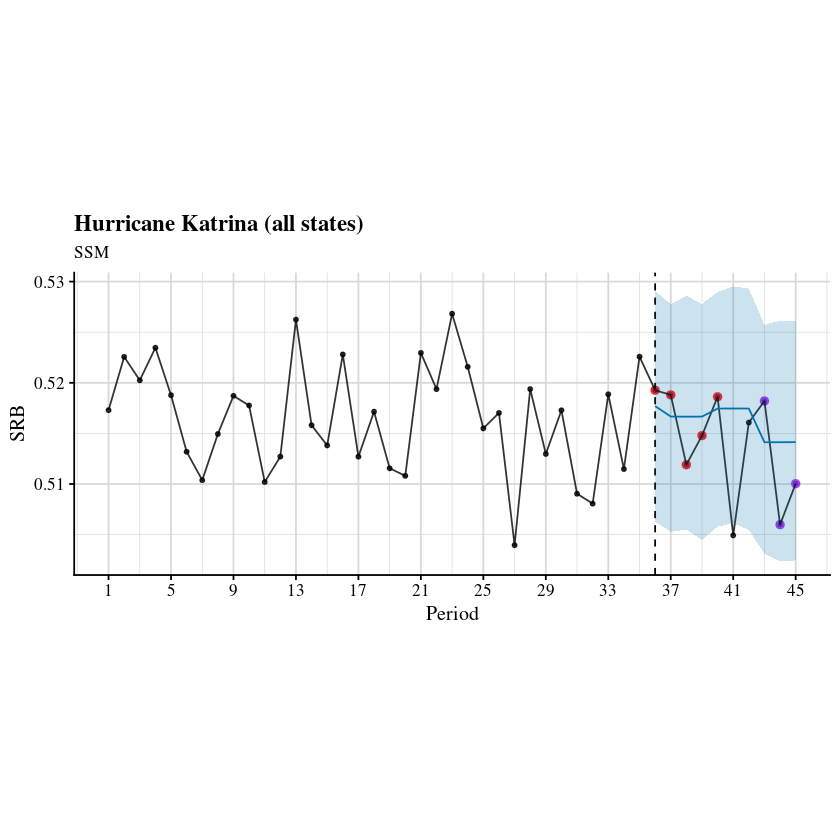

In [38]:
p_causal_katrina_mo_all

### LA and MS only

In [39]:
fips_lams <-
    read_table(
        file = str_c(basedir, "regression/FIPS_LA_MS.csv"), col_names = FALSE
    ) %>%
    pull()

Parsed with column specification:
cols(
  X1 = col_double()
)


In [40]:
dat_katrina_mo_lams <-
    list(
        df = dat_katrina_mo_all$df %>%
             dplyr::filter(FIPS %in% fips_lams),
        intv_period = dat_katrina_mo_all$intv_period
    )

In [41]:
df_katrina_mo_lams <-
    dat_katrina_mo_lams$df %>%
    get_summarised_data()

In [42]:
arima_katrina_mo_lams <-
    df_katrina_mo_lams %>%
    fit_arima(
        .period = dat_katrina_mo_lams$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        max.order = 48,
        max.D = 12,
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [43]:
arima_katrina_mo_lams

Series: . 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
          ar1    mean
      -0.4146  0.5271
s.e.   0.1526  0.0041

sigma^2 estimated as 0.001204:  log likelihood=68.91
AIC=-131.81   AICc=-131.04   BIC=-127.15

In [44]:
resfit_arima_katrina_mo_lams <-
    lm(formula = arima_katrina_mo_lams$residuals ~ 1)

In [45]:
bg_arima_katrina_mo_lams <-
    resfit_arima_katrina_mo_lams %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [46]:
print(bg_arima_katrina_mo_lams)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 17.658, df = 13, p-value = 0.1709



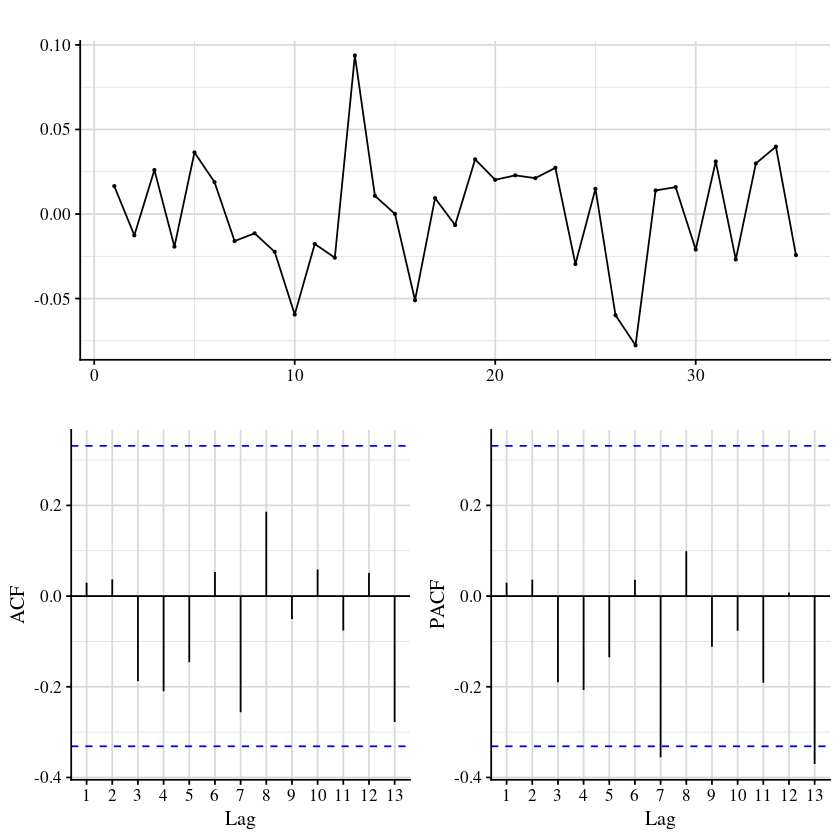

In [47]:
resfit_arima_katrina_mo_lams %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [48]:
pred_arima_katrina_mo_lams <-
    arima_katrina_mo_lams %>%
    get_arima_forecasts(
        df = df_katrina_mo_lams,
        h = 10,
        level = 95
    )

Joining, by = "period"

In [49]:
pred_arima_katrina_mo_lams

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-24,2003-01-20,78,143,0.5454545,NA,NA,NA
2,2003-01-21,2003-02-17,107,211,0.5071090,NA,NA,NA
3,2003-02-18,2003-03-17,123,219,0.5616438,NA,NA,NA
4,2003-03-18,2003-04-14,118,239,0.4937238,NA,NA,NA
5,2003-04-15,2003-05-12,134,232,0.5775862,NA,NA,NA
6,2003-05-13,2003-06-09,104,198,0.5252525,NA,NA,NA
7,2003-06-10,2003-07-07,127,248,0.5120968,NA,NA,NA
8,2003-07-08,2003-08-04,118,226,0.5221239,NA,NA,NA
9,2003-08-05,2003-09-01,108,213,0.5070423,NA,NA,NA


In [50]:
pred_arima_katrina_mo_lams %>%
    dplyr::filter(
        period >= dat_katrina_mo_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:07 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   36 & 0.5379 & 0.4726 & 0.6086 \\ 
     37 & 0.4889 & 0.4479 & 0.5952 \\ 
     38 & 0.5356 & 0.4549 & 0.6040 \\ 
     39 & 0.5966 & 0.4515 & 0.6009 \\ 
     40 & 0.5096 & 0.4528 & 0.6023 \\ 
     41 & 0.4970 & 0.4522 & 0.6017 \\ 
     42 & 0.5458 & 0.4525 & 0.6019 \\ 
     43 & 0.5112 & 0.4524 & 0.6018 \\ 
     44 & 0.5041 & 0.4524 & 0.6019 \\ 
     45 & 0.5105 & 0.4524 & 0.6019 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi} 
\end{table}


In [51]:
p_arima_katrina_mo_lams <-
    pred_arima_katrina_mo_lams %>%
    plot_pred(
        .period = dat_katrina_mo_lams$intv_period,
        .title = "Katrina (Louisiana and Mississippi)"
    ) +
    labs(subtitle = "ARIMA")

In [52]:
p_arima_katrina_mo_lams %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_katrina_arima_lams.pdf")
    )

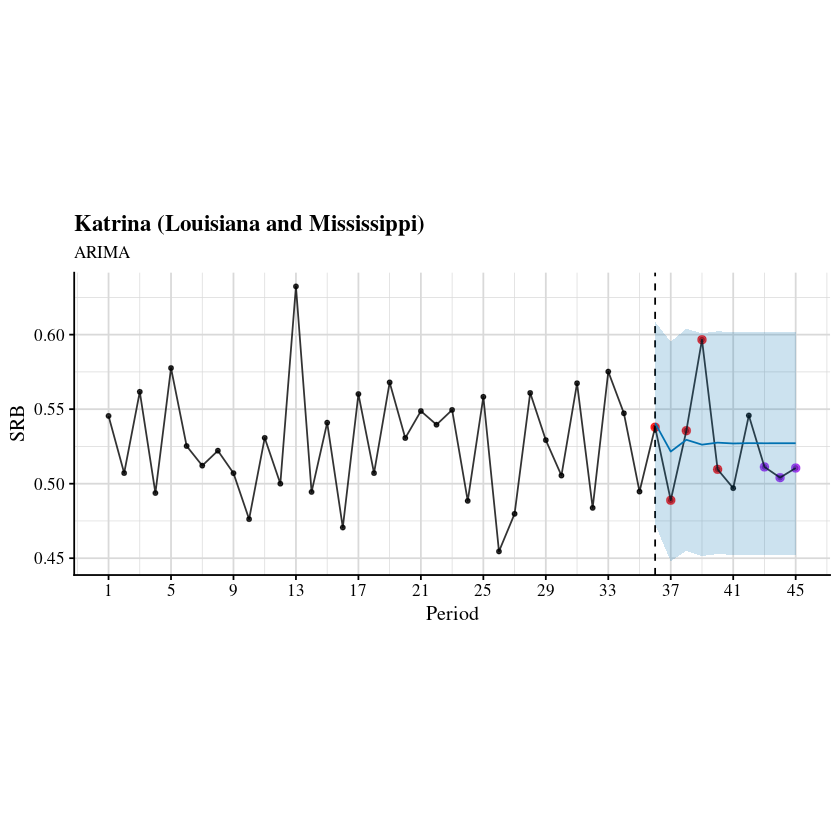

In [53]:
p_arima_katrina_mo_lams

#### CausalImpact

In [54]:
bsts_katrina_mo_lams <-
    df_katrina_mo_lams %>%
    get_ssm_causal(
        .intv = dat_katrina_mo_lams$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:08 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:08 2020 =-=-=-=-=


In [55]:
causal_katrina_mo_lams <-
    df_katrina_mo_lams %>%
    dplyr::filter(
        period >= dat_katrina_mo_lams$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_katrina_mo_lams$model,
        post.period.response = .
    )

In [56]:
df_causal_katrina_mo_lams <-
    causal_katrina_mo_lams$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [57]:
pred_causal_katrina_mo_lams <-
    df_causal_katrina_mo_lams %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [58]:
pred_causal_katrina_mo_lams %>%
    dplyr::filter(period >= dat_katrina_mo_lams$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:08 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   36 & 0.5379 & 0.4382 & 0.6037 \\ 
     37 & 0.4889 & 0.4443 & 0.6109 \\ 
     38 & 0.5356 & 0.4415 & 0.6067 \\ 
     39 & 0.5966 & 0.4445 & 0.6106 \\ 
     40 & 0.5096 & 0.4417 & 0.6094 \\ 
     41 & 0.4970 & 0.4430 & 0.6112 \\ 
     42 & 0.5458 & 0.4417 & 0.6121 \\ 
     43 & 0.5112 & 0.4534 & 0.6211 \\ 
     44 & 0.5041 & 0.4467 & 0.6141 \\ 
     45 & 0.5105 & 0.4436 & 0.6218 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi} 
\end{table}


In [59]:
p_causal_katrina_mo_lams <-
    pred_causal_katrina_mo_lams %>%
    plot_pred(
        .period = dat_katrina_mo_lams$intv_period,
        .title = "Katrina (Louisiana and Mississippi)"
    ) +
    labs(subtitle = "SSM")

In [60]:
p_causal_katrina_mo_lams %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_katrina_ssm_lams.pdf")
    )

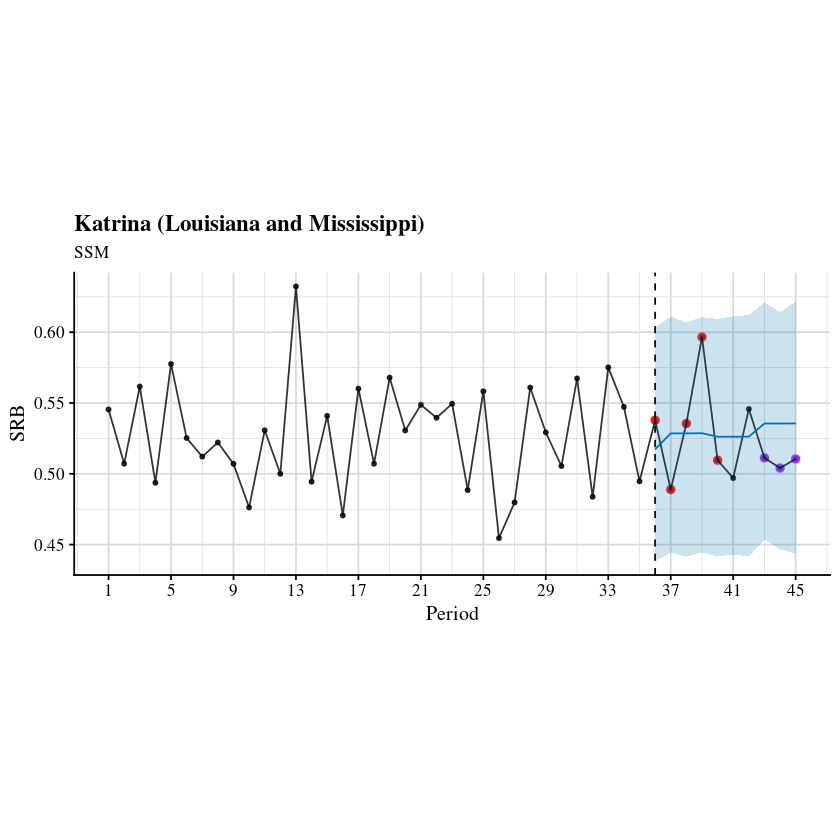

In [61]:
p_causal_katrina_mo_lams

## Virginia Tech (16 April, 2007)

In [20]:
.vtech <- as_date("2007-04-16")

In [21]:
dat_vtech_mo_all <- 
    dat %>%
    add_periods(
        start = .start, intv = `.vtech`, len = 28, filter = 10
    )

Intervention on day 1567.


In [22]:
dat_vtech_mo_all$intv_period

[1] 57

In [23]:
df_vtech_mo_all <- 
    dat_vtech_mo_all$df %>%
    get_summarised_data()

In [24]:
df_vtech_mo_all

period,period_start,period_end,Count,Sum,y
<dbl>,<date>,<date>,<int>,<int>,<dbl>
1,2002-12-30,2003-01-26,3474,6696,0.5188172
2,2003-01-27,2003-02-23,3974,7583,0.5240670
3,2003-02-24,2003-03-23,4230,8150,0.5190184
4,2003-03-24,2003-04-20,4227,8108,0.5213370
5,2003-04-21,2003-05-18,4203,8091,0.5194661
6,2003-05-19,2003-06-15,4070,8000,0.5087500
7,2003-06-16,2003-07-13,4130,8019,0.5150268
8,2003-07-14,2003-08-10,4189,8081,0.5183764
9,2003-08-11,2003-09-07,4102,7929,0.5173414


In [25]:
df_vtech_mo_all %>%
    write_delim(
        path = str_c(basedir, "ts_vtech_mo_all.tsv"),
        delim = "\t"
    )

### All states

#### ARIMA

In [67]:
arima_vtech_mo_all <-
    df_vtech_mo_all %>%
    fit_arima(
        .period = dat_vtech_mo_all$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        max.order = 48,
        max.D = 12, 
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [68]:
arima_vtech_mo_all

Series: . 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.8830
s.e.   0.0671

sigma^2 estimated as 2.018e-05:  log likelihood=219
AIC=-434.01   AICc=-433.78   BIC=-429.99

In [69]:
pred_arima_vtech_mo_all <-
    arima_vtech_mo_all %>%
    get_arima_forecasts(
        df = df_vtech_mo_all,
        h = 10,
        level = 95
    )

Joining, by = "period"

In [70]:
pred_arima_vtech_mo_all

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-30,2003-01-26,3474,6696,0.5188172,NA,NA,NA
2,2003-01-27,2003-02-23,3974,7583,0.5240670,NA,NA,NA
3,2003-02-24,2003-03-23,4230,8150,0.5190184,NA,NA,NA
4,2003-03-24,2003-04-20,4227,8108,0.5213370,NA,NA,NA
5,2003-04-21,2003-05-18,4203,8091,0.5194661,NA,NA,NA
6,2003-05-19,2003-06-15,4070,8000,0.5087500,NA,NA,NA
7,2003-06-16,2003-07-13,4130,8019,0.5150268,NA,NA,NA
8,2003-07-14,2003-08-10,4189,8081,0.5183764,NA,NA,NA
9,2003-08-11,2003-09-07,4102,7929,0.5173414,NA,NA,NA


In [71]:
resfit_arima_vtech_mo_all <-
    lm(formula = arima_vtech_mo_all$residuals ~ 1)

In [72]:
bg_arima_vtech_mo_all <-
    resfit_arima_vtech_mo_all %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [73]:
print(bg_arima_vtech_mo_all)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 11.533, df = 13, p-value = 0.5663



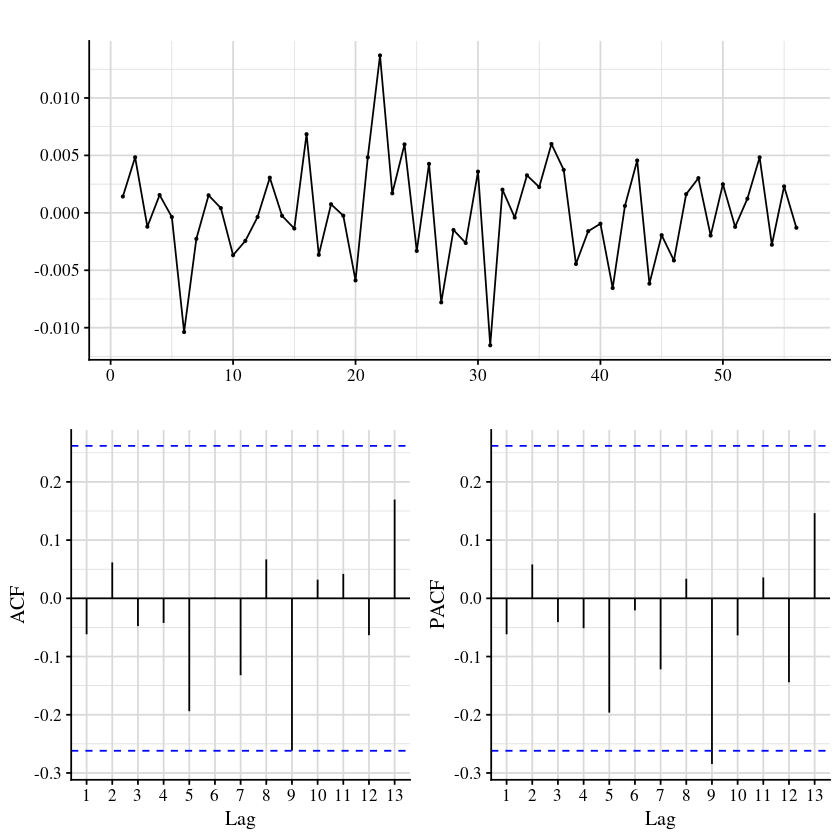

In [74]:
resfit_arima_vtech_mo_all %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [75]:
pred_arima_vtech_mo_all %>%
    dplyr::filter(
        period >= dat_vtech_mo_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:11 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   57 & 0.5046 & 0.5043 & 0.5220 \\ 
     58 & 0.5145 & 0.5043 & 0.5220 \\ 
     59 & 0.5096 & 0.5042 & 0.5221 \\ 
     60 & 0.5169 & 0.5042 & 0.5221 \\ 
     61 & 0.5052 & 0.5041 & 0.5222 \\ 
     62 & 0.5142 & 0.5040 & 0.5222 \\ 
     63 & 0.5156 & 0.5040 & 0.5223 \\ 
     64 & 0.5181 & 0.5039 & 0.5224 \\ 
     65 & 0.5082 & 0.5039 & 0.5224 \\ 
     66 & 0.5110 & 0.5038 & 0.5225 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Virginia Tech Shooting in all states} 
\end{table}


In [76]:
p_arima_vtech_mo_all <-
    pred_arima_vtech_mo_all %>%
    plot_pred(
        .period = dat_vtech_mo_all$intv_period,
        .title = "Virginia Tech Shooting (all states)"
    ) +
    labs(subtitle = "ARIMA")

In [77]:
p_arima_vtech_mo_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_vtech_arima_all_states.pdf")
    )

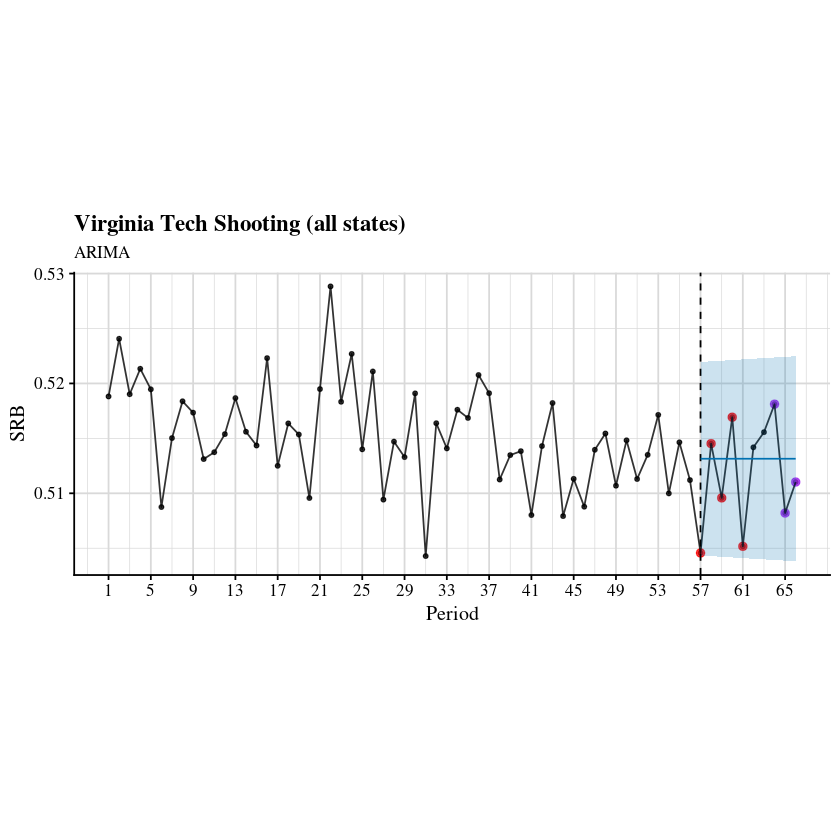

In [78]:
p_arima_vtech_mo_all

#### CausalImpact

In [79]:
bsts_vtech_all <-
    df_vtech_mo_all %>%
    get_ssm_causal(
        .intv = dat_vtech_mo_all$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:13 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:13 2020 =-=-=-=-=


In [80]:
causal_vtech_all <-
    df_vtech_mo_all %>%
    dplyr::filter(
        period >= dat_vtech_mo_all$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_vtech_all$model,
        post.period.response = .
    )

In [81]:
df_causal_vtech_all <-
    causal_vtech_all$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [82]:
pred_causal_vtech_all <-
    df_causal_vtech_all %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [83]:
pred_causal_vtech_all %>%
    dplyr::filter(period >= dat_vtech_mo_all$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:13 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   57 & 0.5046 & 0.5036 & 0.5210 \\ 
     58 & 0.5145 & 0.5062 & 0.5249 \\ 
     59 & 0.5096 & 0.5053 & 0.5245 \\ 
     60 & 0.5169 & 0.5052 & 0.5247 \\ 
     61 & 0.5052 & 0.5042 & 0.5237 \\ 
     62 & 0.5142 & 0.5040 & 0.5233 \\ 
     63 & 0.5156 & 0.5031 & 0.5236 \\ 
     64 & 0.5181 & 0.5029 & 0.5231 \\ 
     65 & 0.5082 & 0.5035 & 0.5229 \\ 
     66 & 0.5110 & 0.5023 & 0.5235 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Virginia Tech Shooting in all states} 
\end{table}


In [84]:
p_causal_vtech_all <-
    pred_causal_vtech_all %>%
    plot_pred(
        .period = dat_vtech_mo_all$intv_period,
        .title = "Virginia Tech Shooting (all states)"
    ) +
    labs(subtitle = "SSM")

In [85]:
p_causal_vtech_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_vtech_ssm_all_states.pdf")
    )

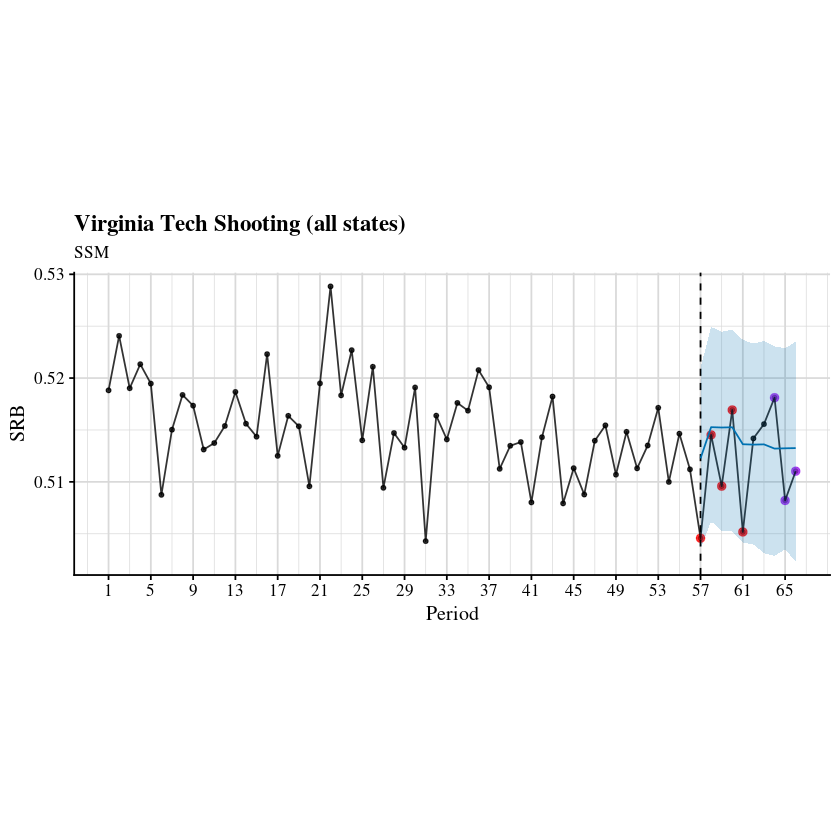

In [86]:
p_causal_vtech_all

### Adjacent states only

In [87]:
fips_adj <-
    read_table(
        file = str_c(basedir, "regression/FIPS_VA_adj.csv"),
        col_names = FALSE
    ) %>%
    pull()

Parsed with column specification:
cols(
  X1 = col_double()
)


In [88]:
dat_vtech_mo_adj <-
    list(
        df = dat_vtech_mo_all$df %>%
             dplyr::filter(FIPS %in% fips_adj),
        intv_period = dat_vtech_mo_all$intv_period
    )

In [89]:
df_vtech_mo_adj <-
    dat_vtech_mo_adj$df %>%
    get_summarised_data()

In [90]:
arima_vtech_mo_adj <-
    df_vtech_mo_adj %>%
    fit_arima(
        .period = dat_vtech_mo_adj$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        max.order = 48,
        max.D = 12,
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [91]:
arima_vtech_mo_adj

Series: . 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.5161
s.e.  0.0019

sigma^2 estimated as 0.0001975:  log likelihood=159.88
AIC=-315.77   AICc=-315.54   BIC=-311.72

In [92]:
resfit_arima_vtech_mo_adj <-
    lm(formula = arima_vtech_mo_adj$residuals ~ 1)

In [93]:
bg_arima_vtech_mo_adj <-
    resfit_arima_vtech_mo_adj %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [94]:
print(bg_arima_vtech_mo_adj)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 17.278, df = 13, p-value = 0.1869



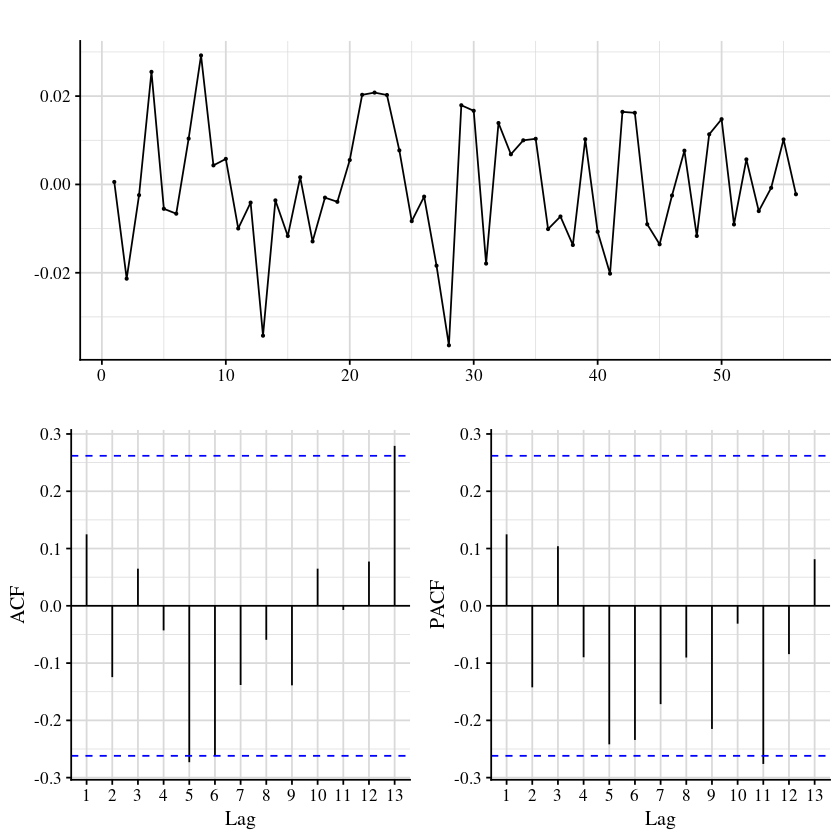

In [95]:
resfit_arima_vtech_mo_adj %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [96]:
pred_arima_vtech_mo_adj <-
    arima_vtech_mo_adj %>%
    get_arima_forecasts(
        df = df_vtech_mo_adj,
        h = 10,
        level = 95
    )

Joining, by = "period"

In [97]:
pred_arima_vtech_mo_adj

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-30,2003-01-26,356,689,0.5166909,NA,NA,NA
2,2003-01-27,2003-02-23,380,768,0.4947917,NA,NA,NA
3,2003-02-24,2003-03-23,431,839,0.5137068,NA,NA,NA
4,2003-03-24,2003-04-20,449,829,0.5416164,NA,NA,NA
5,2003-04-21,2003-05-18,433,848,0.5106132,NA,NA,NA
6,2003-05-19,2003-06-15,402,789,0.5095057,NA,NA,NA
7,2003-06-16,2003-07-13,417,792,0.5265152,NA,NA,NA
8,2003-07-14,2003-08-10,439,805,0.5453416,NA,NA,NA
9,2003-08-11,2003-09-07,420,807,0.5204461,NA,NA,NA


In [98]:
pred_arima_vtech_mo_adj %>%
    dplyr::filter(
        period >= dat_vtech_mo_adj$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:16 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   57 & 0.5110 & 0.4886 & 0.5437 \\ 
     58 & 0.5203 & 0.4886 & 0.5437 \\ 
     59 & 0.5026 & 0.4886 & 0.5437 \\ 
     60 & 0.5280 & 0.4886 & 0.5437 \\ 
     61 & 0.5324 & 0.4886 & 0.5437 \\ 
     62 & 0.5092 & 0.4886 & 0.5437 \\ 
     63 & 0.5315 & 0.4886 & 0.5437 \\ 
     64 & 0.5129 & 0.4886 & 0.5437 \\ 
     65 & 0.5139 & 0.4886 & 0.5437 \\ 
     66 & 0.5344 & 0.4886 & 0.5437 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states} 
\end{table}


In [99]:
p_arima_vtech_mo_adj <-
    pred_arima_vtech_mo_adj %>%
    plot_pred(
        .period = dat_vtech_mo_adj$intv_period,
        .title = "Virginia Tech Shooting (adjacent states only)"
    ) +
    labs(subtitle = "ARIMA")

In [100]:
p_arima_vtech_mo_adj %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_vtech_arima_adjacent.pdf")
    )

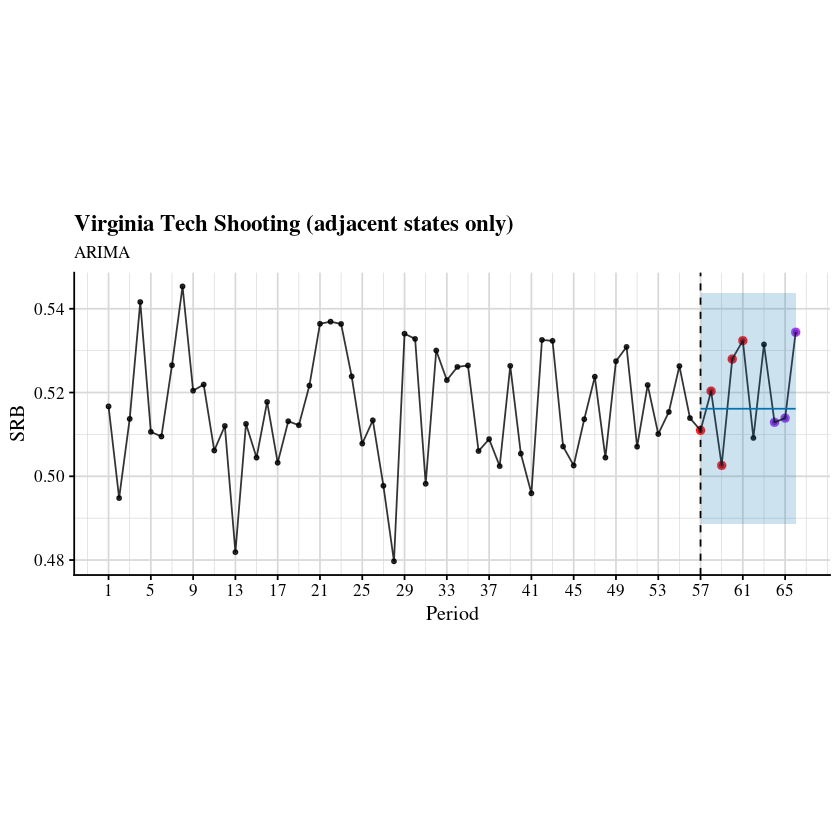

In [101]:
p_arima_vtech_mo_adj

#### CausalImpact

In [102]:
bsts_vtech_adj <-
    df_vtech_mo_adj %>%
    get_ssm_causal(
        .intv = dat_vtech_mo_adj$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:16 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:18 2020 =-=-=-=-=


In [103]:
causal_vtech_adj <-
    df_vtech_mo_adj %>%
    dplyr::filter(
        period >= dat_vtech_mo_adj$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_vtech_adj$model,
        post.period.response = .
    )

In [104]:
df_causal_vtech_adj <-
    causal_vtech_adj$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [105]:
pred_causal_vtech_adj <-
    df_causal_vtech_adj %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [106]:
pred_causal_vtech_adj %>%
    dplyr::filter(
        period >= dat_vtech_mo_adj$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:18 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
   57 & 0.5110 & 0.4922 & 0.5497 \\ 
     58 & 0.5203 & 0.4908 & 0.5486 \\ 
     59 & 0.5026 & 0.4898 & 0.5470 \\ 
     60 & 0.5280 & 0.4907 & 0.5485 \\ 
     61 & 0.5324 & 0.4831 & 0.5404 \\ 
     62 & 0.5092 & 0.4826 & 0.5398 \\ 
     63 & 0.5315 & 0.4815 & 0.5410 \\ 
     64 & 0.5129 & 0.4843 & 0.5441 \\ 
     65 & 0.5139 & 0.4865 & 0.5439 \\ 
     66 & 0.5344 & 0.4856 & 0.5434 \\ 
   \bottomrule
\end{tabular}
\caption{10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states} 
\end{table}


In [107]:
p_causal_vtech_adj <-
    pred_causal_vtech_adj %>%
    plot_pred(
        .period = dat_vtech_mo_adj$intv_period,
        .title = "Virginia Tech Shooting (adjacent states only)"
    ) +
    labs(subtitle = "SSM")

In [108]:
p_causal_vtech_adj %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_mo_vtech_ssm_adjacent.pdf")
    )

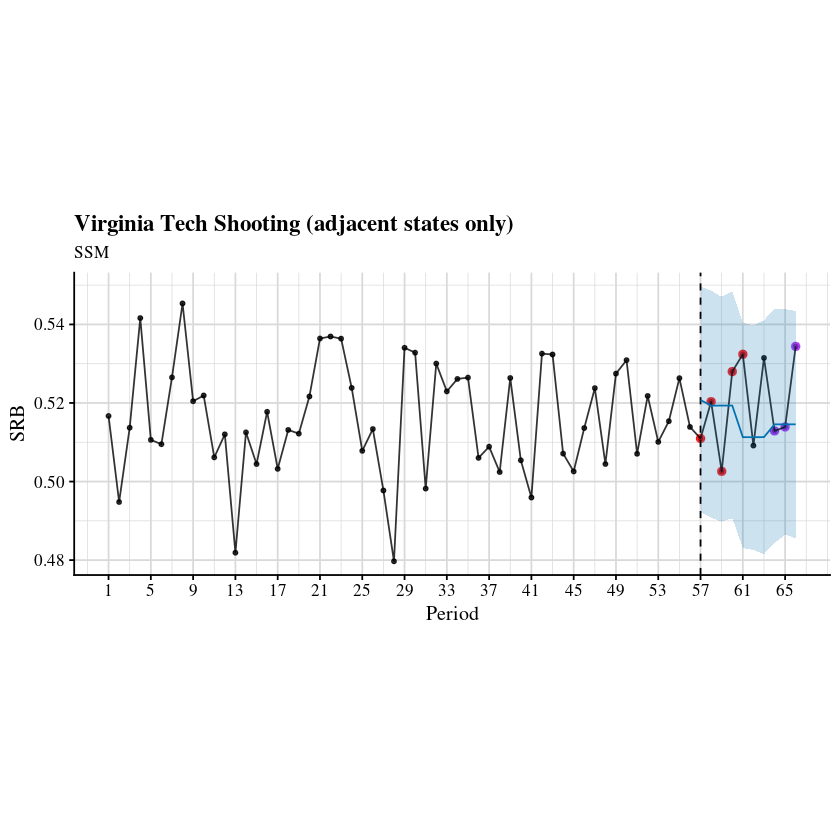

In [109]:
p_causal_vtech_adj